In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.stats as stat
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
data = pd.read_csv('Preliminary Processed Data.csv')

In [3]:
data.columns

Index(['Type', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'Easy Apply', 'Salary Min', 'Salary Max', 'Salary Avg', 'Location City',
       'Location State', 'Headquarter State', 'Period', 'Competitors Count'],
      dtype='object')

## Remove NA cols
使用 ['Rating', 'Size', 'Revenue', 'Salary Avg','Period', 'Competitors Count'] 做分群    
因此移除這些欄位有缺值的資料

In [4]:
data = data[~((data['Rating'] < 0) | (data['Size'] == '-1') | (data['Size'] == 'Unknown') | (data['Founded'] == -1) | (data['Revenue'] == '-1') | (data['Revenue'] == 'Unknown / Non-Applicable'))]

In [5]:
data.groupby(by=['Type']).size()

Type
Business Analyst    2482
Data Analyst        1213
Data Engineer       1479
Data Scientist      2137
dtype: int64

## 處理公司規模及公司營收欄位

In [18]:
data['Size'].unique()

array(['51 to 200 employees', '1001 to 5000 employees',
       '501 to 1000 employees', '10000+ employees', '1 to 50 employees',
       '201 to 500 employees', '5001 to 10000 employees'], dtype=object)

In [19]:
data['Size_le'] = data['Size'].map({
    '1 to 50 employees': 1, 
    '51 to 200 employees': 2, 
    '201 to 500 employees': 3, 
    '501 to 1000 employees': 4, 
    '1001 to 5000 employees': 5, 
    '5001 to 10000 employees': 6,
    '10000+ employees': 7
})

In [20]:
data['Revenue_le'] = data['Revenue'].map({
    'Less than $1 million (USD)': 1,
    '$1 to $5 million (USD)': 2,
    '$5 to $10 million (USD)': 3,
    '$10 to $25 million (USD)': 4, 
    '$25 to $50 million (USD)': 5,
    '$50 to $100 million (USD)': 6, 
    '$100 to $500 million (USD)': 7, 
    '$500 million to $1 billion (USD)': 8,
    '$1 to $2 billion (USD)': 9,
    '$2 to $5 billion (USD)': 10, 
    '$5 to $10 billion (USD)': 11, 
    '$10+ billion (USD)': 12,  
})


## Group by Company

In [21]:
len((data['Company Name'] + data['Location State']).unique())

3027

In [22]:
len(data['Company Name'].unique())

2241

In [23]:
data['Company'] = data['Company Name'] + data['Location State']

In [25]:
company_df = data.groupby(by=['Company']).mean()

In [26]:
company_df.head()

,Rating,Founded,Easy Apply,Salary Min,Salary Max,Salary Avg,Period,Competitors Count,Size_le,Revenue_le
Company,,,,,,,,,,
1-800-Flowers NY,2.8,1976.0,-1.0,129.0,210.0,169.5,44.0,2.0,5.0,9.0
1-800-Flowers.com IL,2.8,1976.0,-1.0,91.0,105.0,98.0,44.0,2.0,5.0,9.0
10th Magnitude IL,4.6,2010.0,-1.0,64.0,104.0,84.0,10.0,2.0,1.0,3.0
120VC CA,4.6,2000.0,-1.0,102.0,160.0,131.0,20.0,13.0,2.0,4.0
22nd Century Technologies AZ,3.7,1997.0,1.0,44.0,83.0,63.5,23.0,2.0,5.0,5.0


## Kmeans Clustering

In [27]:
cols = ['Rating', 'Size_le', 'Revenue_le', 'Salary Avg','Period', 'Competitors Count']

In [28]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(company_df[cols])
    distortions.append(kmeanModel.inertia_)

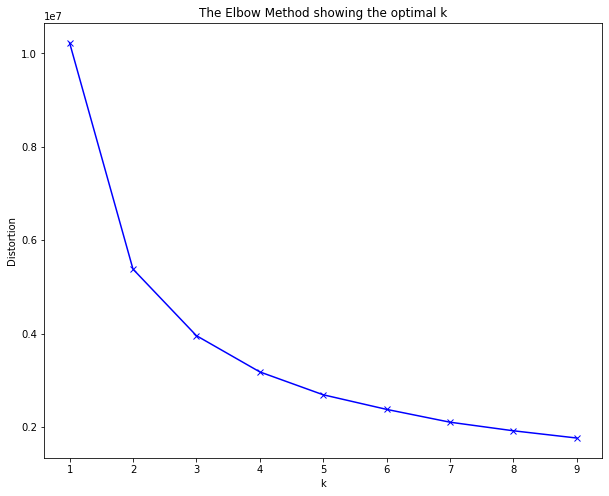

In [29]:
plt.figure(figsize=(10,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(company_df[cols])

KMeans(n_clusters=4)

In [31]:
company_df['Cluster'] = kmeanModel.predict(company_df[cols])

In [32]:
company_df.groupby(by=['Cluster']).size()

Cluster
0    1616
1     430
2     793
3     188
dtype: int64

<AxesSubplot:xlabel='Cluster', ylabel='Revenue_le'>

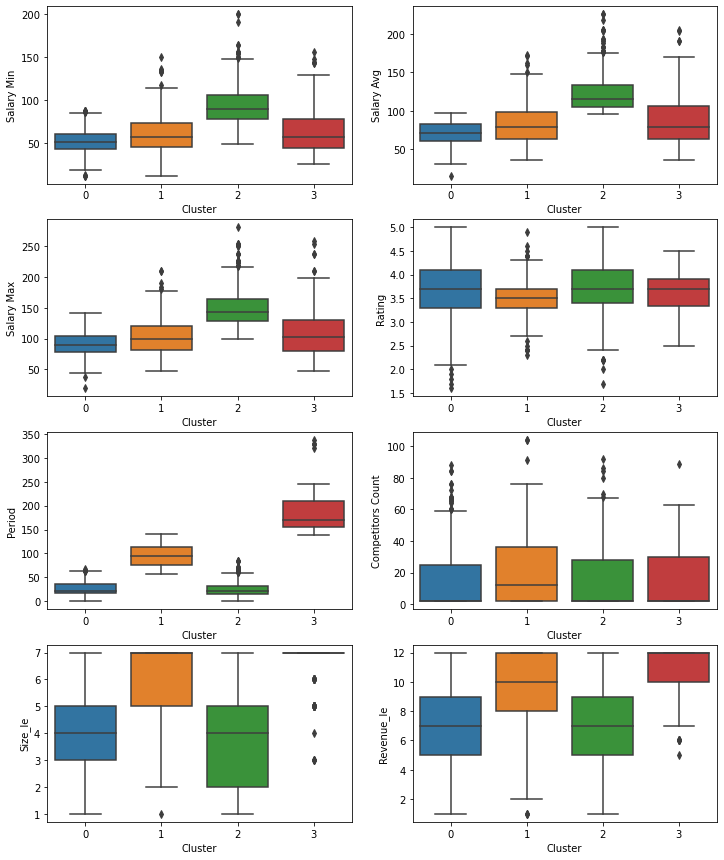

In [33]:
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))
sns.boxplot(data=company_df, y="Salary Min", x="Cluster", ax=axes[0, 0])
sns.boxplot(data=company_df, y="Salary Avg", x="Cluster", ax=axes[0, 1])
sns.boxplot(data=company_df, y="Salary Max", x="Cluster", ax=axes[1, 0])
sns.boxplot(data=company_df, y="Rating", x="Cluster", ax=axes[1, 1])
sns.boxplot(data=company_df, y="Period", x="Cluster", ax=axes[2, 0])
sns.boxplot(data=company_df, y="Competitors Count", x="Cluster", ax=axes[2, 1])
sns.boxplot(data=company_df, y="Size_le", x="Cluster", ax=axes[3, 0])
sns.boxplot(data=company_df, y="Revenue_le", x="Cluster", ax=axes[3, 1])

In [34]:
company_df.groupby(by=['Cluster', 'Size_le']).size().unstack()

Size_le,1.0,2.0,3.0,4.0,5.0,6.0,6.5,7.0
Cluster,,,,,,,,
0,109.0,289.0,267.0,173.0,394.0,113.0,NaN,271.0
1,1.0,5.0,20.0,27.0,97.0,54.0,1.0,225.0
2,53.0,171.0,113.0,95.0,176.0,47.0,NaN,138.0
3,NaN,NaN,4.0,1.0,19.0,13.0,NaN,151.0


In [35]:
company_df.groupby(by=['Cluster', 'Revenue_le']).size().unstack()

Revenue_le,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,11.4,12.0
Cluster,,,,,,,,,,,,,
0,23.0,74.0,66.0,195.0,171.0,195.0,340.0,117.0,91.0,135.0,67.0,1.0,141.0
1,3.0,2.0,1.0,3.0,6.0,15.0,59.0,25.0,58.0,66.0,57.0,NaN,135.0
2,10.0,51.0,42.0,83.0,82.0,100.0,160.0,39.0,59.0,61.0,27.0,NaN,79.0
3,NaN,NaN,NaN,NaN,1.0,7.0,4.0,5.0,14.0,24.0,13.0,NaN,120.0


In [36]:
company_df.to_csv('kmeans result-company.csv', index=False)

## 分群分析

In [37]:
company_df.groupby(by=['Cluster']).mean().T

Cluster,0,1,2,3
Rating,3.708159,3.511142,3.747388,3.636466
Founded,1993.873267,1924.312791,1995.303909,1835.946809
Easy Apply,-0.917450,-0.981395,-0.880538,-0.989362
Salary Min,52.268042,60.910034,94.411794,64.400274
Salary Max,90.570327,103.334809,149.998537,110.644507
Salary Avg,71.419184,82.122422,122.205165,87.522391
Period,26.126733,95.687209,24.696091,184.053191
Competitors Count,12.923515,19.734884,13.977301,14.611702
Size_le,4.161510,5.975581,4.088272,6.627660
Revenue_le,6.868441,9.730233,6.807062,10.978723


In [38]:
company_df.groupby(by=['Cluster']).min()[cols].T

Cluster,0,1,2,3
Rating,1.60,2.3,1.7,2.5
Size_le,1.00,1.0,1.0,3.0
Revenue_le,1.00,1.0,1.0,5.0
Salary Avg,15.84,36.5,96.0,36.5
Period,0.00,57.0,0.0,139.0
Competitors Count,2.00,2.0,2.0,2.0


In [39]:
company_df.groupby(by=['Cluster']).max()[cols].T

Cluster,0,1,2,3
Rating,5.0000,4.9,5.0,4.5
Size_le,7.0000,7.0,7.0,7.0
Revenue_le,12.0000,12.0,12.0,12.0
Salary Avg,97.0625,172.0,225.0,205.0
Period,67.0000,140.0,85.0,338.0
Competitors Count,88.0000,104.0,92.0,89.0


## 1. 檢定變數

#### 事前檢定

In [40]:
def pretest(col):
    print(
        '-----------------------常態分布檢查-----------------------',
        '\nCluster 0:', stat.shapiro(company_df[company_df['Cluster']==0][[col]]),
        '\nCluster 1:', stat.shapiro(company_df[company_df['Cluster']==1][[col]]),
        '\nCluster 2:', stat.shapiro(company_df[company_df['Cluster']==2][[col]]),
        '\nCluster 3:', stat.shapiro(company_df[company_df['Cluster']==3][[col]]),
    )
    print(
        '-----------------------同質變異數檢查----------------------\n',
        stat.levene(company_df[company_df['Cluster']==0][col], company_df[company_df['Cluster']==1][col], company_df[company_df['Cluster']==2][col], company_df[company_df['Cluster']==3][col], center = 'mean')
    )


#### Ony-way anova

In [41]:
def anova(col):
    print(stat.f_oneway(company_df[company_df['Cluster']==0][col], company_df[company_df['Cluster']==1][col], company_df[company_df['Cluster']==2][col], company_df[company_df['Cluster']==3][col]))

#### Post hoc

In [42]:
def tukey(col):
    print(pairwise_tukeyhsd(endog=company_df[col], groups=company_df['Cluster'], alpha=0.05))

### 檢定 Avg Rating

In [43]:
pretest('Rating')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9908177852630615, pvalue=1.544988492696575e-08) 
Cluster 1: ShapiroResult(statistic=0.9868268966674805, pvalue=0.0006181128555908799) 
Cluster 2: ShapiroResult(statistic=0.9892051815986633, pvalue=1.413481732015498e-05) 
Cluster 3: ShapiroResult(statistic=0.9675446152687073, pvalue=0.00023756043810863048)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=36.60349279875494, pvalue=3.1358437651038875e-23)


In [44]:
anova('Rating')

F_onewayResult(statistic=19.92499519467296, pvalue=8.706256821161218e-13)


In [45]:
tukey('Rating')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   -0.197  0.001 -0.2722 -0.1218   True
     0      2   0.0392  0.336 -0.0209  0.0993  False
     0      3  -0.0717  0.311 -0.1785  0.0351  False
     1      2   0.2362  0.001  0.1532  0.3193   True
     1      3   0.1253 0.0396  0.0041  0.2465   True
     2      3  -0.1109 0.0549 -0.2234  0.0015  False
----------------------------------------------------


### 檢定 Avg Salary

In [46]:
pretest('Salary Avg')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9827049374580383, pvalue=4.870653034540207e-13) 
Cluster 1: ShapiroResult(statistic=0.9554912447929382, pvalue=4.2024342339352927e-10) 
Cluster 2: ShapiroResult(statistic=0.8776351809501648, pvalue=1.7991718298317976e-24) 
Cluster 3: ShapiroResult(statistic=0.9221493005752563, pvalue=1.8863943296310026e-08)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=139.4114774297984, pvalue=1.3314030455476018e-84)


In [47]:
anova('Salary Avg')

F_onewayResult(statistic=1198.6649459105222, pvalue=0.0)


In [48]:
tukey('Salary Avg')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1  10.7032 0.001   7.9657  13.4408   True
     0      2   50.786 0.001  48.5986  52.9734   True
     0      3  16.1032 0.001  12.2156  19.9908   True
     1      2  40.0827 0.001  37.0613  43.1041   True
     1      3      5.4 0.009   0.9889   9.8111   True
     2      3 -34.6828 0.001 -38.7752 -30.5903   True
-----------------------------------------------------


### 檢定 Min Salary

In [49]:
pretest('Salary Min')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9919754266738892, pvalue=1.0171741848807869e-07) 
Cluster 1: ShapiroResult(statistic=0.9515038132667542, pvalue=1.1345543254881463e-10) 
Cluster 2: ShapiroResult(statistic=0.9238487482070923, pvalue=1.370200644757538e-19) 
Cluster 3: ShapiroResult(statistic=0.9196465015411377, pvalue=1.2465943832751236e-08)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=120.25739870676988, pvalue=1.4120533674592188e-73)


In [50]:
anova('Salary Min')

F_onewayResult(statistic=1052.3127918683608, pvalue=0.0)


In [51]:
tukey('Salary Min')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1    8.642  0.001  6.2161 11.0679   True
     0      2  42.1438  0.001 40.2054 44.0821   True
     0      3  12.1322  0.001  8.6873 15.5772   True
     1      2  33.5018  0.001 30.8244 36.1791   True
     1      3   3.4902 0.0993 -0.4186  7.3991  False
     2      3 -30.0115  0.001 -33.638 -26.385   True
----------------------------------------------------


### 檢定 Max Salary

In [52]:
pretest('Salary Max')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9920002818107605, pvalue=1.0608864187133804e-07) 
Cluster 1: ShapiroResult(statistic=0.9622367024421692, pvalue=4.603687209225882e-09) 
Cluster 2: ShapiroResult(statistic=0.9241681694984436, pvalue=1.5047064162132545e-19) 
Cluster 3: ShapiroResult(statistic=0.9209707975387573, pvalue=1.5505518646818928e-08)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=124.46086874770033, pvalue=5.183817224492324e-76)


In [53]:
anova('Salary Max')

F_onewayResult(statistic=1059.5660358640528, pvalue=0.0)


In [54]:
tukey('Salary Max')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1  12.7645  0.001    9.358  16.1709   True
     0      2  59.4282  0.001  56.7063  62.1501   True
     0      3  20.0742  0.001  15.2366  24.9117   True
     1      2  46.6637  0.001  42.9041  50.4234   True
     1      3   7.3097 0.0035   1.8208  12.7986   True
     2      3  -39.354  0.001 -44.4465 -34.2616   True
------------------------------------------------------


### 檢定 Period

In [55]:
pretest('Period')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9330194592475891, pvalue=2.5109089782818994e-26) 
Cluster 1: ShapiroResult(statistic=0.9518983960151672, pvalue=1.287482759293468e-10) 
Cluster 2: ShapiroResult(statistic=0.9255695939064026, pvalue=2.27700747253251e-19) 
Cluster 3: ShapiroResult(statistic=0.8303400278091431, pvalue=1.5738782889809788e-13)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=198.8217721779483, pvalue=1.1032721346211243e-117)


In [56]:
anova('Period')

F_onewayResult(statistic=5709.977123573828, pvalue=0.0)


In [57]:
tukey('Period')

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1  69.5605 0.001  67.0292  72.0918   True
     0      2  -1.4306 0.265  -3.4532   0.5919  False
     0      3 157.9265 0.001 154.3318 161.5211   True
     1      2 -70.9911 0.001 -73.7849 -68.1974   True
     1      3   88.366 0.001  84.2873  92.4447   True
     2      3 159.3571 0.001  155.573 163.1412   True
-----------------------------------------------------


### 檢定 Competitors Count

In [58]:
pretest('Competitors Count')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.675434947013855, pvalue=0.0) 
Cluster 1: ShapiroResult(statistic=0.8150772452354431, pvalue=7.325307839816547e-22) 
Cluster 2: ShapiroResult(statistic=0.7098777890205383, pvalue=7.485159447093208e-35) 
Cluster 3: ShapiroResult(statistic=0.7282364368438721, pvalue=2.916924051737184e-17)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=13.534214293751637, pvalue=9.02985888888622e-09)


In [59]:
anova('Competitors Count')

F_onewayResult(statistic=16.20599342519426, pvalue=1.8940148587996142e-10)


In [60]:
tukey('Competitors Count')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   6.8114  0.001   4.292  9.3307   True
     0      2   1.0538 0.5299 -0.9592  3.0668  False
     0      3   1.6882 0.6044 -1.8895  5.2659  False
     1      2  -5.7576  0.001 -8.5381  -2.977   True
     1      3  -5.1232 0.0065 -9.1826 -1.0637   True
     2      3   0.6344    0.9 -3.1318  4.4006  False
----------------------------------------------------


### 檢定 Size

In [61]:
pretest('Size_le')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9203075170516968, pvalue=2.1436541579290254e-28) 
Cluster 1: ShapiroResult(statistic=0.7744609117507935, pvalue=6.790823116756411e-24) 
Cluster 2: ShapiroResult(statistic=0.9126981496810913, pvalue=6.1646786256347286e-21) 
Cluster 3: ShapiroResult(statistic=0.49618959426879883, pvalue=6.573563408166035e-23)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=110.87955204229934, pvalue=4.118378415637345e-68)


In [62]:
anova('Size_le')

F_onewayResult(statistic=225.62082761641312, pvalue=4.4036793994825654e-132)


In [63]:
tukey('Size_le')

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   1.8141  0.001  1.5685  2.0597   True
     0      2  -0.0732 0.7467 -0.2695   0.123  False
     0      3   2.4661  0.001  2.1174  2.8149   True
     1      2  -1.8873  0.001 -2.1584 -1.6163   True
     1      3   0.6521  0.001  0.2564  1.0478   True
     2      3   2.5394  0.001  2.1723  2.9065   True
----------------------------------------------------


### 檢定 Revenue

In [64]:
pretest('Revenue_le')

-----------------------常態分布檢查----------------------- 
Cluster 0: ShapiroResult(statistic=0.9610812664031982, pvalue=2.1369749067387177e-20) 
Cluster 1: ShapiroResult(statistic=0.8699968457221985, pvalue=1.7175839834919787e-18) 
Cluster 2: ShapiroResult(statistic=0.9574931263923645, pvalue=2.1994032097416745e-14) 
Cluster 3: ShapiroResult(statistic=0.6694478988647461, pvalue=5.841520017540159e-19)
-----------------------同質變異數檢查----------------------
 LeveneResult(statistic=26.66099649580577, pvalue=5.1393509103376385e-17)


In [65]:
anova('Revenue_le')

F_onewayResult(statistic=248.78257729055963, pvalue=2.7994758698063306e-144)


In [66]:
tukey('Revenue_le')

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   2.8618 0.001  2.4853  3.2383   True
     0      2  -0.0614   0.9 -0.3622  0.2395  False
     0      3   4.1103 0.001  3.5756   4.645   True
     1      2  -2.9232 0.001 -3.3387 -2.5076   True
     1      3   1.2485 0.001  0.6418  1.8552   True
     2      3   4.1717 0.001  3.6088  4.7345   True
---------------------------------------------------


## 2. 查看各群體內部分布概況

In [68]:
company_df[company_df['Cluster']==0].index

Index(['10th Magnitude IL', '22nd Century Technologies AZ',
       '22nd Century Technologies CA', '22nd Century Technologies CO',
       '22nd Century Technologies FL', '22nd Century Technologies IL',
       '22nd Century Technologies NY', '22nd Century Technologies TX', '2U NY',
       '3degrees TX',
       ...
       'iSpace, Inc. CA', 'iTech Solutions, Inc PA',
       'iVenture Solutions, Inc. FL',
       'iland Internet Solutions Corporation TX', 'ingenium.agency AZ',
       'nana TX', 'neteffects AZ', 'pureIntegration NC', 'vtech Solutions AZ',
       'xentity corporation CO'],
      dtype='object', name='Company', length=1616)

In [74]:
company_df['Company Name']  = company_df.index.str.rsplit(' ').str[:-1]
company_df['Location'] = company_df.index.str.rsplit(' ').str[-1]

In [77]:
company_df['Company Name']  = company_df['Company Name'].apply(lambda x: ' '.join(map(str, x)))

In [80]:
company_df.groupby(by=['Cluster', 'Location']).size().unstack()

Location,AZ,CA,CO,DE,FL,GA,IL,IN,KS,Kingdom,NC,NJ,NY,OH,PA,SC,TX,UT,VA,WA
Cluster,,,,,,,,,,,,,,,,,,,,
0,141.0,211.0,40.0,15.0,101.0,1.0,172.0,12.0,2.0,NaN,33.0,40.0,110.0,28.0,109.0,2.0,552.0,9.0,17.0,21.0
1,32.0,88.0,7.0,1.0,23.0,NaN,53.0,2.0,NaN,NaN,4.0,10.0,40.0,12.0,24.0,NaN,129.0,1.0,2.0,2.0
2,36.0,387.0,NaN,10.0,2.0,NaN,50.0,NaN,NaN,NaN,NaN,29.0,104.0,4.0,43.0,NaN,128.0,NaN,NaN,NaN
3,10.0,26.0,1.0,7.0,10.0,1.0,16.0,1.0,NaN,1.0,3.0,17.0,29.0,7.0,21.0,NaN,34.0,2.0,1.0,1.0


In [85]:
company_df.groupby(by=['Cluster', 'Company Name']).size().unstack().T.to_csv('Cluster Company list.csv')

In [104]:
data_cluster = data.merge(company_df[['Cluster']], on='Company', how='left')

In [181]:
data_cluster.to_csv('Cluster Result.csv', index=False)

### Cluster - Job Type Test on Salary

In [114]:
obs = np.array(data_cluster.groupby(by=['Type', 'Cluster']).mean()[['Salary Avg']].unstack())

In [115]:
stat.chi2_contingency(obs, correction = False)[1]

0.9904016327254354

In [116]:
obs1 = np.array(data_cluster.groupby(by=['Type', 'Cluster']).mean()[['Salary Min']].unstack())

In [117]:
stat.chi2_contingency(obs1, correction = False)[1]

0.9957636915580282

In [118]:
obs2 = np.array(data_cluster.groupby(by=['Type', 'Cluster']).mean()[['Salary Max']].unstack())

In [119]:
stat.chi2_contingency(obs2, correction = False)[1]

0.9744470847815319

In [160]:
data_cluster.groupby(by=['Cluster', 'Sector']).size().unstack().fillna(0)

Sector,-1,Accounting & Legal,Aerospace & Defense,Agriculture & Forestry,"Arts, Entertainment & Recreation",Biotech & Pharmaceuticals,Business Services,"Construction, Repair & Maintenance",Consumer Services,Education,...,Media,Mining & Metals,Non-Profit,"Oil, Gas, Energy & Utilities",Real Estate,"Restaurants, Bars & Food Services",Retail,Telecommunications,Transportation & Logistics,Travel & Tourism
Cluster,,,,,,,,,,,,,,,,,,,,,
0,55.0,48.0,98.0,3.0,10.0,78.0,1002.0,15.0,4.0,42.0,...,31.0,1.0,36.0,48.0,11.0,8.0,46.0,33.0,29.0,1.0
1,16.0,15.0,67.0,0.0,3.0,62.0,187.0,6.0,0.0,40.0,...,28.0,0.0,6.0,41.0,2.0,2.0,76.0,10.0,16.0,3.0
2,13.0,12.0,28.0,0.0,2.0,93.0,402.0,7.0,4.0,9.0,...,59.0,0.0,4.0,21.0,5.0,3.0,25.0,16.0,17.0,0.0
3,1.0,10.0,0.0,0.0,0.0,57.0,15.0,0.0,0.0,27.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,9.0,0.0,0.0


In [143]:
df = data_cluster[data_cluster['Location State']!=' United Kingdom'].groupby(by=['Cluster', 'Location State']).size().unstack().fillna(0)

In [144]:
df

Location State,AZ,CA,CO,DE,FL,GA,IL,IN,KS,NC,NJ,NY,OH,PA,SC,TX,UT,VA,WA
Cluster,,,,,,,,,,,,,,,,,,,
0,345.0,434.0,50.0,23.0,241.0,3.0,354.0,14.0,2.0,46.0,67.0,193.0,50.0,280.0,2.0,1567.0,11.0,27.0,33.0
1,89.0,211.0,9.0,2.0,87.0,0.0,120.0,2.0,0.0,8.0,14.0,77.0,55.0,54.0,0.0,421.0,1.0,2.0,2.0
2,75.0,1087.0,0.0,12.0,2.0,0.0,93.0,0.0,0.0,0.0,34.0,181.0,11.0,73.0,0.0,313.0,0.0,0.0,0.0
3,70.0,71.0,1.0,13.0,51.0,1.0,32.0,1.0,0.0,3.0,23.0,63.0,17.0,60.0,0.0,120.0,2.0,1.0,1.0


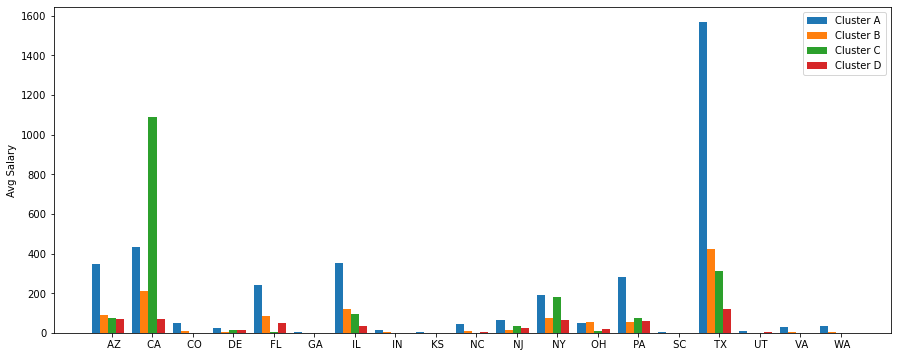

In [161]:
states = df.columns
plt.figure(figsize=(15,6))
x = np.arange(len(states))
width = 0.2
plt.bar(x - 1.5 * width, df.iloc[0], width, label='Cluster A')
plt.bar(x - width/2, df.iloc[1], width, label='Cluster B')
plt.bar(x + width/2, df.iloc[2], width, label='Cluster C')
plt.bar(x + 1.5 * width, df.iloc[3], width, label='Cluster D')
plt.xticks(x + width/2, states)
plt.ylabel('Avg Salary')
plt.legend()
plt.show()

In [153]:
df2 = data_cluster[data_cluster['Type of ownership']!='Unknown'].groupby(by=['Cluster', 'Type of ownership']).size().unstack().fillna(0)

In [154]:
df2

Type of ownership,College / University,Company - Private,Company - Public,Contract,Government,Hospital,Nonprofit Organization,Other Organization,Private Practice / Firm,School / School District,Self-employed,Subsidiary or Business Segment
Cluster,,,,,,,,,,,,
0,25.0,2278.0,1042.0,14.0,31.0,8.0,101.0,3.0,8.0,2.0,2.0,201.0
1,38.0,241.0,577.0,0.0,19.0,8.0,201.0,3.0,13.0,1.0,0.0,52.0
2,0.0,948.0,753.0,1.0,5.0,0.0,31.0,0.0,4.0,1.0,0.0,135.0
3,26.0,29.0,400.0,0.0,28.0,12.0,26.0,1.0,0.0,2.0,0.0,10.0


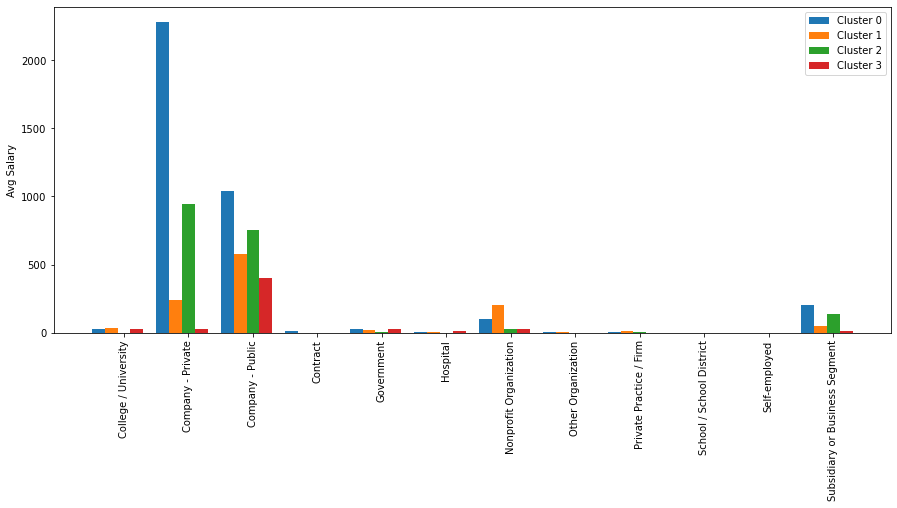

In [159]:
own = df2.columns
plt.figure(figsize=(15,6))
x = np.arange(len(own))
width = 0.2
plt.bar(x - 1.5 * width, df2.iloc[0], width, label='Cluster 0')
plt.bar(x - width/2, df2.iloc[1], width, label='Cluster 1')
plt.bar(x + width/2, df2.iloc[2], width, label='Cluster 2')
plt.bar(x + 1.5 * width, df2.iloc[3], width, label='Cluster 3')
plt.xticks(x + width/2, own, rotation=90)
plt.ylabel('Avg Salary')
plt.legend()
plt.show()

## For Data Scientist 公司推薦

In [215]:
data_cluster[(data_cluster['Cluster'] == 2) & (data_cluster['Type'] == 'Data Scientist')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
Scopus IT,CA,Company - Private,225.0,4.2
Twitter,CA,Company - Public,225.0,4.0
Accounting Principals,CA,Company - Public,225.0,3.9
Appen,CA,Company - Public,225.0,3.6
Signature Consultants,CA,Company - Private,225.0,3.6


In [216]:
data_cluster[(data_cluster['Cluster'] == 3) & (data_cluster['Type'] == 'Data Scientist')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
"Marsh & McLennan Companies, Inc.",NY,Company - Public,205.0,3.4
Pfizer,PA,Company - Public,190.0,4.1
"JPMorgan Chase Bank, N.A.",DE,Company - Public,190.0,3.9
Citi,DE,Company - Public,190.0,3.7
Wells Fargo,DE,Company - Public,190.0,3.6


## For Data Engineer 公司推薦

In [217]:
data_cluster[(data_cluster['Cluster'] == 2) & (data_cluster['Type'] == 'Data Engineer')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
EY,PA,Company - Private,217.5,3.8
"Pyramid Consulting, Inc",DE,Company - Private,217.5,3.7
W3Global,CA,Company - Private,204.0,4.5
"TEKsystems, Inc",CA,Subsidiary or Business Segment,204.0,3.9
LanceSoft Inc,CA,Company - Private,204.0,3.8


In [218]:
data_cluster[(data_cluster['Cluster'] == 3) & (data_cluster['Type'] == 'Data Engineer')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
"JPMorgan Chase Bank, N.A.",DE,Company - Public,217.500000,3.9
Aetna,IL,Company - Public,171.500000,3.3
Nokia,CA,Company - Public,153.500000,4.1
GSK,PA,Company - Public,127.666667,3.9
New York Life Insurance Co,NY,Company - Private,119.500000,3.6


## For Data Analyst 公司推薦

In [219]:
data_cluster[(data_cluster['Cluster'] == 2) & (data_cluster['Type'] == 'Data Analyst')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
NVIDIA,CA,Company - Public,150.0,4.6
OSI Engineering,CA,Company - Private,150.0,4.5
Connor Group,CA,Company - Private,150.0,4.0
LeanData,CA,Company - Private,150.0,4.0
Zipongo,CA,Company - Private,150.0,4.0


In [220]:
data_cluster[(data_cluster['Cluster'] == 3) & (data_cluster['Type'] == 'Data Analyst')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
UC San Francisco,CA,College / University,138.5,4.1
Providence Health & Services,CA,Nonprofit Organization,122.5,3.4
Metropolitan Family Services,IL,Company - Private,113.0,3.2
The Bank of New York Mellon,NJ,Company - Public,106.0,3.2
University of California,CA,College / University,99.0,4.2


## For Business Analyst 公司推薦

In [221]:
data_cluster[(data_cluster['Cluster'] == 2) & (data_cluster['Type'] == 'Business Analyst')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
Jobot,CA,Company - Private,172.5,4.9
VBeyond Corporation,CA,Company - Private,172.5,4.4
Cynet Systems,CA,Company - Private,172.5,4.0
Systems Integration Solutions,CA,Company - Private,172.5,3.9
Mumba Technologies,CA,Company - Private,172.5,3.3


In [222]:
data_cluster[(data_cluster['Cluster'] == 3) & (data_cluster['Type'] == 'Business Analyst')].groupby(by=['Company Name', 'Location State', 'Type of ownership']).mean()[['Salary Avg', 'Rating']].sort_values(by=["Salary Avg", "Rating"], ascending=False).head(5)

,,,Salary Avg,Rating
Company Name,Location State,Type of ownership,,
Chubb,PA,Company - Public,153.25,3.3
Bristol-Myers Squibb,CA,Company - Public,128.50,3.8
PNC Financial Services Group,PA,Company - Public,125.75,3.4
Credit Suisse,NY,Company - Public,124.00,3.8
JPMorgan Chase,NJ,Company - Public,120.00,3.9


## 畫圖

In [91]:
df_1 = company_df.groupby(by=['Cluster']).mean()[['Salary Avg']]

In [92]:
df_1

,Salary Avg
Cluster,
0,71.419184
1,82.122422
2,122.205165
3,87.522391


In [95]:
clusters = ['SME', 'Large Enterprise', 'SME with High Salary', 'Centennial Enterprise']

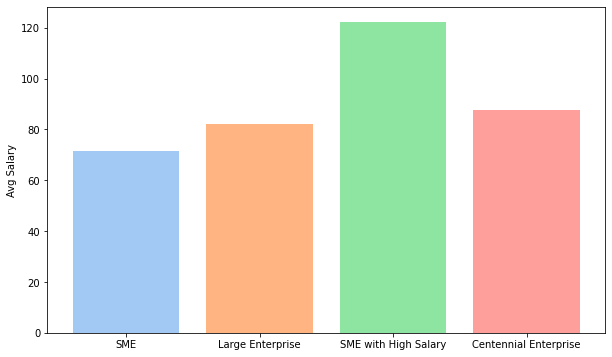

In [97]:
plt.figure(figsize=(10,6))
x = np.arange(len(clusters))
plt.bar(x, df_1['Salary Avg'], color=sns.color_palette('pastel'))
plt.xticks(x, clusters)
plt.ylabel('Avg Salary')
plt.show()

<AxesSubplot:xlabel='Cluster', ylabel='Salary Avg'>

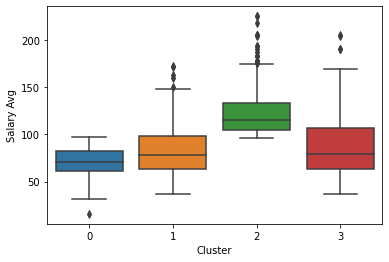

In [98]:
sns.boxplot(data=company_df, y="Salary Avg", x="Cluster")